<a href="https://colab.research.google.com/github/carlosfmorenog/BMVCTemplate/blob/master/CMM536_Topic_9/CMM536_T9_2_Lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CMM536 Topic 9.2 Lab: Bayesian Poisoning in R

**PRO TIP**: To generate a Colab Notebook that runs in R, just click https://colab.to/r and a new notebook will appear!

The purpose of this activity is to demonstrate that the Naïve Bayes (NB) classifier is vulnerable to Bayesian poisoning attacks. Bayesian poisoning is a technique used by email spammers to compromise the effectiveness of Bayesian spam filters by adding non-spamming (ham) words to the end of a spam message.

In [ ]:
# Installing the necessary packages (it takes a loooong time)
install.packages("wordcloud")
install.packages("tm")
install.packages("caret")
install.packages("e1071")

# Loading the necessary packages
library(wordcloud)
library(tm)
library(caret)
library(e1071)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘Rcpp’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘NLP’, ‘slam’, ‘BH’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘shape’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘proxy’, ‘iterators’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘timeDate’, ‘e1071’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: RColorBrewer

Loading required package: NLP

Loading required package: ggplot2


Attaching package: ‘ggplot2’


The following object is masked from ‘package:NLP’:

    annotate


Loading required package: lattice



## Training and Testing the Bayesian Spam Filter

First, we will train a Bayesian based spam filter using raw email messages downloaded from https://www.kaggle.com/venky73/spam-mails-dataset. If you are working locally in your computer, use the link to download `spam_ham_dataset.csv` and store it in the same directory as your R code/notebook. Otherwise, we will load it from my Dropbox account.

Once you have done this, run the following cell to load the dataset into the R environment. You can see it has $5171$ mails and $4$ columns (X, label, text and label_num)

In [ ]:
myData <- read.csv("https://www.dropbox.com/s/prrcj0s7ila2wv6/spam_ham_dataset.csv?raw=1") # read the dataset
myData # see data

X    label
1     605 ham  
2    2349 ham  
3    3624 ham  
4    4685 spam 
5    2030 ham  
6    2949 ham  
7    2793 ham  
8    4185 spam 
9    2641 ham  
10   1870 ham  
11   4922 spam 
12   3799 spam 
13   1488 ham  
14   3948 spam 
15   3418 ham  
16   4791 spam 
17   2643 ham  
18   3137 ham  
19   1629 ham  
20   1858 ham  
21   3261 ham  
22   3447 ham  
23   2459 ham  
24   2221 ham  
25   4827 spam 
26   1811 ham  
27   2367 ham  
28   2829 ham  
29   3512 ham  
30    441 ham  
⋮    ⋮    ⋮    
5142 4453 spam 
5143  747 ham  
5144  992 ham  
5145 4894 spam 
5146 3348 ham  
5147 4961 spam 
5148 2331 ham  
5149 3897 spam 
5150 4647 spam 
5151 2819 ham  
5152 3762 spam 
5153 4778 spam 
5154 2583 ham  
5155 2203 ham  
5156 1904 ham  
5157 1080 ham  
5158  256 ham  
5159 2789 ham  
5160 4381 spam 
5161  760 ham  
5162 4979 spam 
5163 4162 spam 
5164 1428 ham  
5165 4365 spam 
5166 2849 ham  
5167 1518 ham  
5168  404 ham  
5169 2933 ham  
5170 1409 ham  
5171 4807 spam 
     text                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

Let's check how many samples there are from each class by plotting the data distribution from the `label_num` column in a bar chart:


   0    1 
3672 1499 

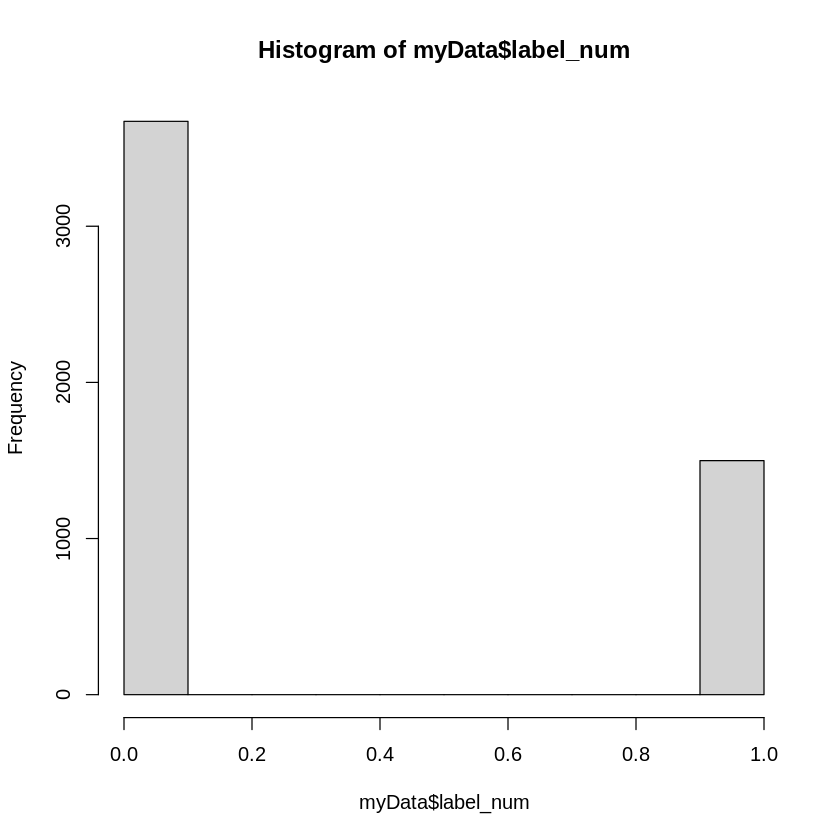

In [ ]:
table(myData$label_num)
hist(myData$label_num)

Notice there are around 2.5 times more 0's (ham) than 1's (spam)!

Now, we will remove the term "Subject:" as is common in every messages. It makes no sense to keep common terms like "Subject:" as they have no discrimination power!

In [ ]:
myData<-myData[,c("label","text")] # select two columns
myData$text<-substring(myData$text,9) # remove "Subject:"
head(myData, n=2)# see the first couple entries

,label,text
,<chr>,<chr>
1,ham,"enron methanol ; meter # : 988291 this is a follow up to the note i gave you on monday , 4 / 3 / 00 { preliminary flow data provided by daren } . please override pop ' s daily volume { presently zero } to reflect daily activity you can obtain from gas control . this change is needed asap for economics purposes ."
2,ham,"hpl nom for january 9 , 2001 ( see attached file : hplnol 09 . xls ) - hplnol 09 . xls"


Let's check the word distributions (i.e. document terms) in each class. For
this purpose, we will use **word clouds**, where the size of the word is proportional to its frequency in the text (we used them in the menti polls!). If the word clouds are different, we can conclude that words that are common in spam are different from words that appear in ham. Hence, we can use words (features) in a text message to classify it as ham or spam.

Warning message in tm_map.SimpleCorpus(corpus, tm::removePunctuation):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(corpus, function(x) tm::removeWords(x, tm::stopwords())):
“transformation drops documents”


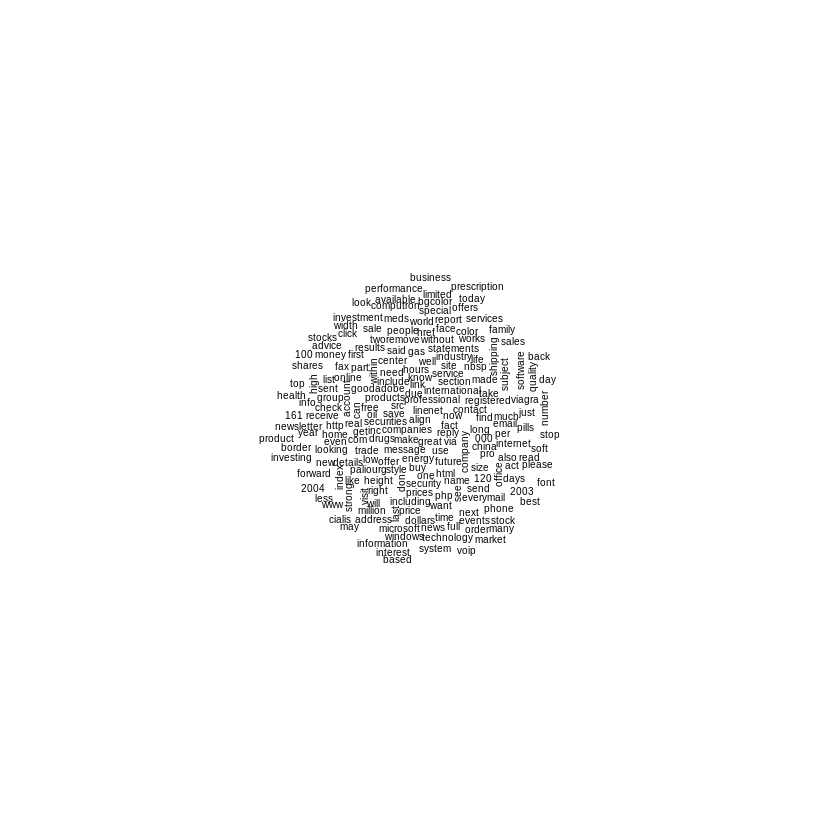

In [ ]:
# For spam
spamMsg<-subset(myData,label=="spam")
wordcloud(spamMsg$text,scale=c(.5,.5),min.freq=100) # plot if the word apperas more than 100 times in the spam messages

Warning message in tm_map.SimpleCorpus(corpus, tm::removePunctuation):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(corpus, function(x) tm::removeWords(x, tm::stopwords())):
“transformation drops documents”


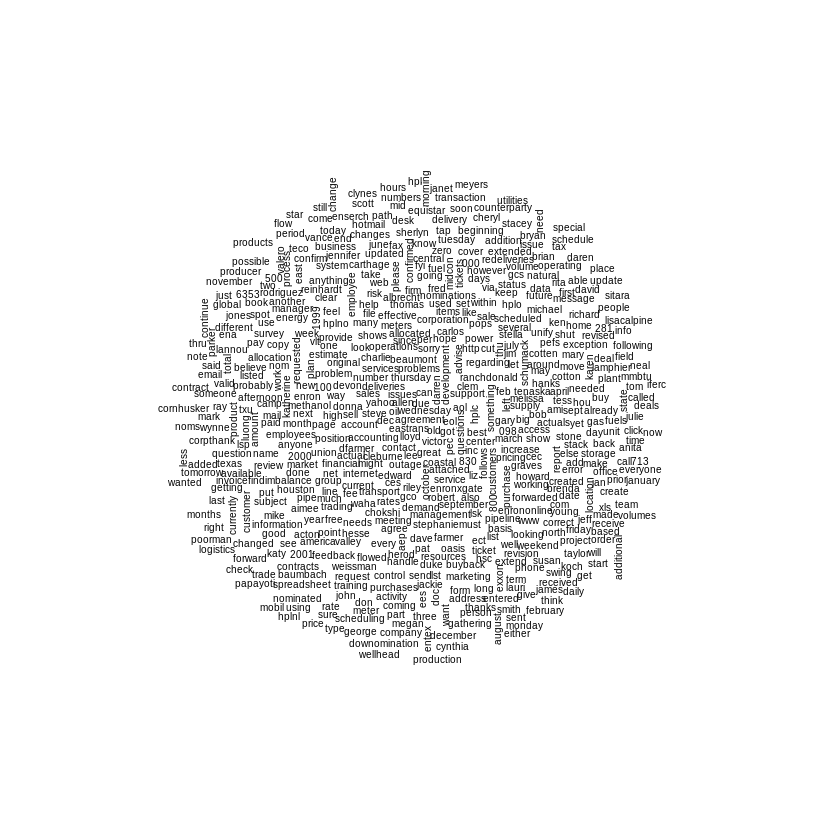

In [ ]:
# For ham
hamMsg<-subset(myData,label=="ham")
wordcloud(hamMsg$text,scale=c(.5,.5),min.freq=100) # plot if the word apperas more than 100 times in the ham messages

As we can see from the word cloud outputs, the term distributions between spam and ham differ. Therfore, we can train an ML model (NB in our case) using words as features:

In [ ]:
# Create a document term matrix i.e. a mtable that describes the frecuency of terms
# occured in each message of our collection
myCorpus <- VCorpus(VectorSource(myData$text)) # create a corpus
myDTM <- DocumentTermMatrix(myCorpus, control = list(tolower=T,
removeNumbers=T,
removePunctuation=T,
stopwords = T,
stem=T))
myDTM

<<DocumentTermMatrix (documents: 5171, terms: 45085)>>
Non-/sparse entries: 309571/232824964
Sparsity           : 100%
Maximal term length: 24
Weighting          : term frequency (tf)

A document term matrix (DTM) is usually a sparse matrix as most of its entries are filled with zeros. Let’s use only terms which have frequency $\geq 5$ as features in our model building. To this end we use the `findFreqTerms()` function in R. This will reduce the number of columns in our DTM matrix to $8615$, which would be a more manageable size in our model building.

In [ ]:
freqWords <- findFreqTerms(myDTM,5)
myDTM <- myDTM[,freqWords]
myDTM

<<DocumentTermMatrix (documents: 5171, terms: 8615)>>
Non-/sparse entries: 256717/44291448
Sparsity           : 99%
Maximal term length: 19
Weighting          : term frequency (tf)

Now, we will split the dataset into train and test sets. We’re going to use an 80/20 partitioning for the training and testing by means of the `createDataPartition()` function from the caret package.

In [ ]:
tr_index <- createDataPartition(myData$label, p=0.80, list=FALSE) # List of 80% of the rows
trainSet <- myData[tr_index,] # select 80% of the data for the trainSet
testSet <- myData[-tr_index,] # Select the remaining 20% of data for testSet

Since we are creating our NB model with the DTM entries, we should obtain the
corresponding DTM entries for the data in `trainSet` and `testSet`.

In [ ]:
myDTMTrain <- myDTM[tr_index,]
myDTMTest <- myDTM[-tr_index,]

To represent the presence or absence of a certain word (feature) in a
particular message, we code our DTM as follows:

In [ ]:
# Create a function called convert_counts to have a true/false table
convert_counts <- function(x) {
x <- ifelse(x > 0, "T", "F")
}
# Apply the function
myDTMTrainNew <- apply(myDTMTrain, MARGIN = 2,convert_counts)
myDTMTestNew <- apply(myDTMTest, MARGIN = 2, convert_counts)

If you print the output, it is a table with T or F depending on the precense/absence of a term

In [ ]:
myDTMTestNew

,aaron,aba,abacha,abacus,abacustech,abazis,abbot,abbott,abc,abdominal,⋯,zinc,zipper,zisman,zivley,zoloft,zone,zonedubai,zones,zwallet,zyban
1,F,F,F,F,F,F,F,F,F,F,⋯,F,F,F,F,F,F,F,F,F,F
7,F,F,F,F,F,F,F,F,F,F,⋯,F,F,F,F,F,F,F,F,F,F
8,F,F,F,F,F,F,F,F,F,F,⋯,F,F,F,F,F,F,F,F,F,F
18,F,F,F,F,F,F,F,F,F,F,⋯,F,F,F,F,F,F,F,F,F,F
21,F,F,F,F,F,F,F,F,F,F,⋯,F,F,F,F,F,F,F,F,F,F
22,F,F,F,F,F,F,F,F,F,F,⋯,F,F,F,F,F,F,F,F,F,F
26,F,F,F,F,F,F,F,F,F,F,⋯,F,F,F,F,F,F,F,F,F,F
30,F,F,F,F,F,F,F,F,F,F,⋯,F,F,F,F,F,F,F,F,F,F
35,F,F,F,F,F,F,F,F,F,F,⋯,F,F,F,F,F,F,F,F,F,F
39,F,F,F,F,F,F,F,F,F,F,⋯,F,F,F,F,F,F,F,F,F,F


Now we build the model. Remember, this only takes one line of code!

In [ ]:
NBbasedSpamFilter <- naiveBayes(myDTMTrainNew, trainSet$label) # train the model

This is how the model looks like:

In [ ]:
NBbasedSpamFilter


Naive Bayes Classifier for Discrete Predictors

Call:
naiveBayes.default(x = myDTMTrainNew, y = trainSet$label)

A-priori probabilities:
trainSet$label
      ham      spam 
0.7100048 0.2899952 

Conditional probabilities:
              aaron
trainSet$label            F            T
          ham  0.9989788972 0.0010211028
          spam 0.9991666667 0.0008333333

              aba
trainSet$label            F            T
          ham  0.9993192648 0.0006807352
          spam 0.9966666667 0.0033333333

              abacha
trainSet$label            F            T
          ham  1.0000000000 0.0000000000
          spam 0.9991666667 0.0008333333

              abacus
trainSet$label            F            T
          ham  0.9979577944 0.0020422056
          spam 0.9991666667 0.0008333333

              abacustech
trainSet$label           F           T
          ham  0.997617427 0.002382573
          spam 1.000000000 0.000000000

              abazis
trainSet$label           F           

Now we test our model:

In [ ]:
testPredictMsgLabel <- predict(NBbasedSpamFilter, myDTMTestNew,) # predict labels for test cases

Let's check the confusion matrix. Notice we get an accuracy of ~90%!

In [ ]:
confusionMatrix(testPredictMsgLabel, as.factor(testSet$label), positive = "spam") # Print confusion matrix

Confusion Matrix and Statistics

          Reference
Prediction ham spam
      ham  701   60
      spam  33  239
                                          
               Accuracy : 0.91            
                 95% CI : (0.8908, 0.9267)
    No Information Rate : 0.7106          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.7751          
                                          
 Mcnemar's Test P-Value : 0.007016        
                                          
            Sensitivity : 0.7993          
            Specificity : 0.9550          
         Pos Pred Value : 0.8787          
         Neg Pred Value : 0.9212          
             Prevalence : 0.2894          
         Detection Rate : 0.2314          
   Detection Prevalence : 0.2633          
      Balanced Accuracy : 0.8772          
                                          
       'Positive' Class : spam            
                           

In addition, we can save our model into a `.rds` file so that we can use it or deploy it later on an IDS server

In [ ]:
saveRDS(NBbasedSpamFilter, "./final_NbbasedSpamFilter.rds")

## Doing the Bayesian Infection

To bypass the spam filter, we need to **poison** the test data! First, we randomly select non-spam messages are amended at the end of the spam messages in our test data set.

In [ ]:
spamTestCases <- subset(testSet,label=="spam") # select spams in test cases
hamTestCases <- subset(testSet, label=="ham") # select ham in test cases
hamMsgInmyData<-subset(myData, label=="ham") # select ham in our original dataset
hamMsg2ammend<-hamMsgInmyData[sample(nrow(hamMsgInmyData), nrow(spamTestCases)),]
# select number of ham messages equal to the spam messages in test cases
spamTestCases$text <-paste(spamTestCases$text,hamMsg2ammend$text,sep = " ") # amend selected ham at the end of spams in test cases
poisTestData<-rbind(hamTestCases,spamTestCases) # create the poisoned test set
myData[-tr_index,]<-poisTestData # replace the test entries in original dataset with poisoned test cases

Now, we create the new DTM with poisoned data and select high frequency words:

In [ ]:
myCorpusPoisoned <- VCorpus(VectorSource(myData$text))
myDTMPoisoned <- DocumentTermMatrix(myCorpusPoisoned, control = list(tolower=T,
removeNumbers=T,
removePunctuation=T,
stopwords = T,
stem=T))
freqWords <- findFreqTerms(myDTMPoisoned,5)
myDTMPoisoned <- myDTMPoisoned[,freqWords]
myDTMTestPoisoned <- myDTMPoisoned[-tr_index,] # new test set, note that we don't need a training set as we use the same model created above
myDTMTestNewPoisoned <- apply(myDTMTestPoisoned, MARGIN = 2, convert_counts) # Using the same convert_counts function, we code our poisoned test DTM as above.

Finally, we try again to predict labels, but now for the poisoned test cases.

In [ ]:
poisonedTestPredictMsgLabel <- predict(NBbasedSpamFilter, myDTMTestNewPoisoned)
confusionMatrix(poisonedTestPredictMsgLabel, as.factor(testSet$label), positive = "spam") # Print confusion matrix for poisoned data

Confusion Matrix and Statistics

          Reference
Prediction ham spam
      ham  640  249
      spam  94   50
                                          
               Accuracy : 0.668           
                 95% CI : (0.6383, 0.6966)
    No Information Rate : 0.7106          
    P-Value [Acc > NIR] : 0.9987          
                                          
                  Kappa : 0.0463          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.1672          
            Specificity : 0.8719          
         Pos Pred Value : 0.3472          
         Neg Pred Value : 0.7199          
             Prevalence : 0.2894          
         Detection Rate : 0.0484          
   Detection Prevalence : 0.1394          
      Balanced Accuracy : 0.5196          
                                          
       'Positive' Class : spam            
                           

As you can see in the confusion matrix, classifications of spam as ham (false negatives) increase in the poisoned test cases. Now our accuracy sits at ~66%!